# Twitter Hate Speech Detection using Random Forest Classifier
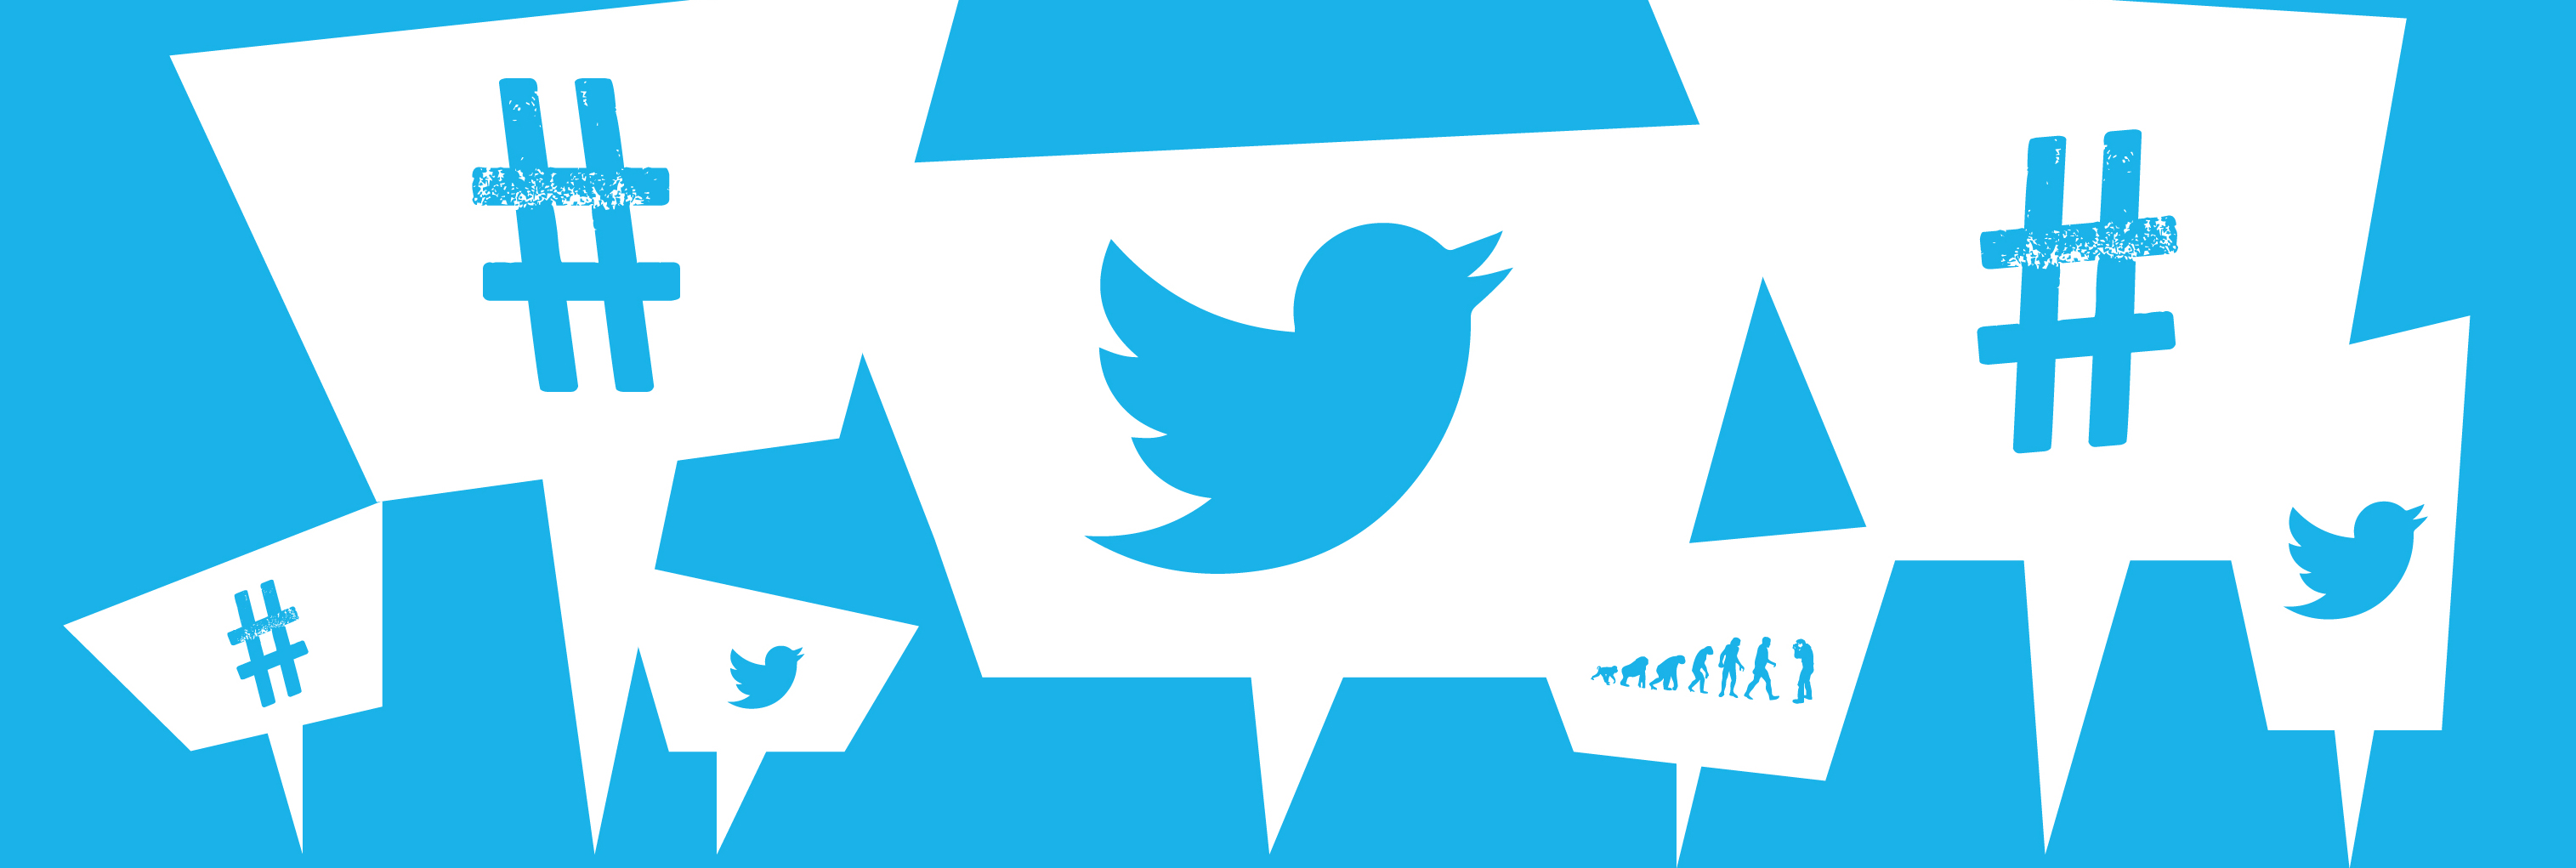

# Importing the libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing the dataset

In [47]:
dataset = pd.read_csv('labeled_data.csv')
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [48]:
dataset.shape

(24783, 7)

In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [50]:
dataset.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


# Taking class and tweets in different dataframe

In [51]:
dt_trasformed = dataset[['class', 'tweet']]
dt_trasformed

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


# Putting class in y

In [52]:
y = dt_trasformed.iloc[:, :-1].values

# OneHotEncoder on y 

In [53]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
y = np.array(ct.fit_transform(y))

In [54]:
print(y)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [55]:
y_df = pd.DataFrame(y)
y_df.head()

,0,1,2
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


# 0 stands for hate, 1 stands for offensive and 2 stands for normal speech

In [56]:
y_hate = np.array(y_df[0])
y_offensive = np.array(y_df[1])
y_normal = np.array(y_df[2])

In [57]:
print(y_hate)
print(y_offensive)
print(y_normal)

[0. 0. 0. ... 0. 0. 0.]
[0. 1. 1. ... 1. 1. 0.]
[1. 0. 0. ... 0. 0. 1.]


# Cleaning the tweet texts

In [58]:
dt_trasformed['tweet']

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [59]:
corpus = []
for i in range(0, 24783):
  review = re.sub('[^a-zA-Z]', ' ', dt_trasformed['tweet'][i])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

In [60]:
cv = CountVectorizer(max_features = 2000)
X = cv.fit_transform(corpus).toarray()

# Splitting the dataset into the Training set and Test set

## for hate speech 

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hate, test_size = 0.20, random_state = 0)

## for offensive speech

In [62]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X, y_offensive, test_size = 0.20, random_state = 0)

## for normal speech

In [63]:
XXX_train, XXX_test, yyy_train, yyy_test = train_test_split(X, y_normal, test_size = 0.20, random_state = 0)

# Random Forest for Hate Speech 

In [64]:
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

# Making the Confusion Matrix for Hate Speech

In [65]:
y_pred_rf = classifier_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

[[4586   92]
 [ 213   66]]


<AxesSubplot:>

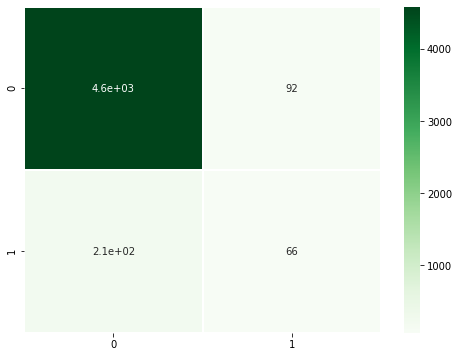

In [66]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot= True, linewidth=1, cmap="Greens")

In [67]:
rf_score = accuracy_score(y_test, y_pred_rf)
print('Accuracy: ',rf_score)

Accuracy:  0.9384708493040145


# Random Forest for Offensive Speech 

In [68]:
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_rf.fit(XX_train, yy_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

# Making the Confusion Matrix for Offensive Speech

In [69]:
#Random Florest
yy_pred_rf = classifier_rf.predict(XX_test)
cm = confusion_matrix(yy_test, yy_pred_rf)
print(cm)

[[ 863  242]
 [ 257 3595]]


<AxesSubplot:>

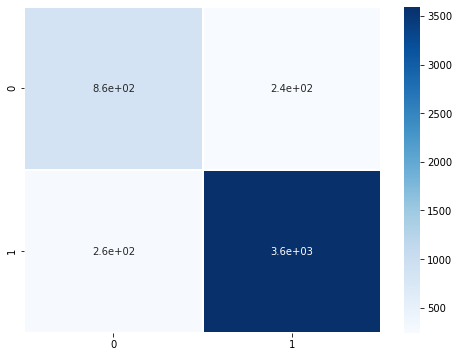

In [70]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot= True, linewidth=1, cmap="Blues")

In [71]:
rrf_score = accuracy_score(yy_test, yy_pred_rf)
print('Accuracy: ',rrf_score)

Accuracy:  0.9003342747629615


# Random Forest for Normal Speech 

In [72]:
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_rf.fit(XXX_train, yyy_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

# Making the Confusion Matrix for Normal Speech

In [73]:
yyy_pred_rf = classifier_rf.predict(XXX_test)
cm = confusion_matrix(yyy_test, yyy_pred_rf)
print(cm)

[[4019  112]
 [ 155  671]]


<AxesSubplot:>

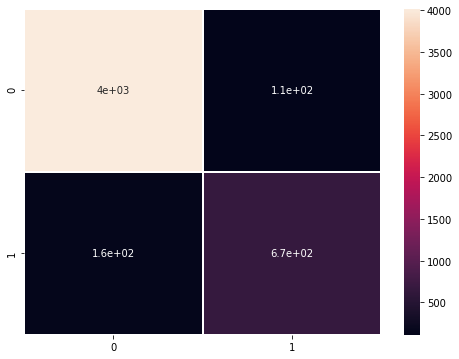

In [74]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot= True, linewidth=1)

In [75]:
rrrf_score = accuracy_score(yyy_test, yyy_pred_rf)
print('Random Forest Accuracy: ',rrrf_score)

Random Forest Accuracy:  0.9461367762759734


# Accuracy

In [76]:
print(" Accuracy of Hate Tweets : ", rf_score)
print("Accuracy of Offensive Tweets :", rrf_score)
print("Accuracy of Normal Tweets :", rrrf_score)

 Accuracy of Hate Tweets :  0.9384708493040145
Accuracy of Offensive Tweets : 0.9003342747629615
Accuracy of Normal Tweets : 0.9461367762759734


# This model can Predict Normal, Hate and Offensive Tweets with Excellent Accuracy